# 1. Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as  sns

In [2]:
viscoe_df = pd.read_csv('TPA_Datasets.csv')
viscoe_df.tail()

,SPA_Label,baPWV,beta,Ep,EDR,E_temp,Eta_temp,Age,Sex,Smoking,...,Aspirin,BMI,SBP,DBP,HDL,LDL,TotalChol,Glucose,ProteinUria,Tri
100,2,2684,9.411957,1311.851254,21.4058,2137,189,84,1,0.0,...,NaN,22.038567,140,80,29.0,105.0,179.6,98,0.0,228.0
101,2,2757,8.960341,1401.863132,9.5997,1905,64,84,1,0.0,...,NaN,22.038567,135,82,29.0,105.0,179.6,102,0.0,228.0
102,2,1374,4.743801,567.175130,13.3286,1140,92,61,1,0.0,...,0.0,27.379665,123,77,40.0,77.0,133.8,92,0.0,84.0
103,2,1644,9.560268,1137.257199,6.2775,5353,132,67,0,1.0,...,0.0,22.506925,156,95,31.0,106.0,205.6,142,NaN,343.0
104,2,2269,9.248431,934.951542,29.3880,1669,212,78,1,0.0,...,0.0,24.092971,138,74,NaN,NaN,120.0,86,0.0,NaN


<Axes: xlabel='SPA_Label', ylabel='count'>

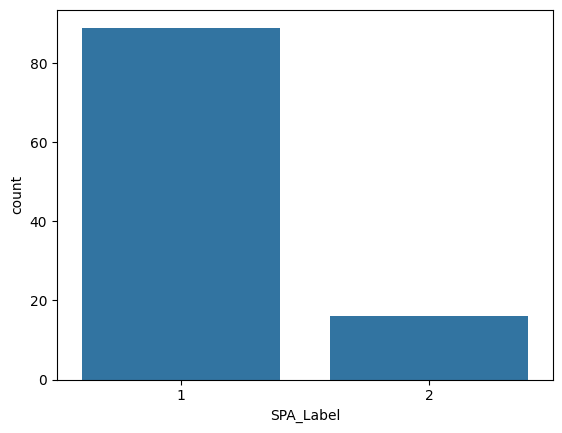

In [3]:
sns.countplot(data=viscoe_df, x='TPA_Label')  #visualise data with label

In [5]:
viscoe_df.columns

# Select features
feature_df = viscoe_df[['beta', 'Ep', 'EDR', 'Age', 'Sex', 'SBP', 'Smoking', 'HDL', 'LDL ',
       'Glucose']]

# Independent variable (features)
X = np.asarray(feature_df)

# Dependent variable (target)
y = np.asarray(viscoe_df['TPA_Label'])

print(X)


[[   6.53585731  611.4937981     4.2665     ...   48.
   126.          101.        ]
 [   6.94967859  636.9976292    12.2671     ...   52.
   140.8          80.        ]
 [  11.5220574  1279.833525      3.6963     ...   35.
   135.          106.        ]
 ...
 [   4.74380147  567.1751302    13.3286     ...   40.
    77.           92.        ]
 [   9.56026814 1137.257199      6.2775     ...   31.
   106.          142.        ]
 [   9.24843071  934.9515419    29.388      ...           nan
            nan   86.        ]]


In [6]:
import numpy as np
from sklearn.impute import KNNImputer

# Impute missing values using KNNImputer
nan = np.nan
imputer = KNNImputer(n_neighbors=6, weights="uniform")
X_imputed = imputer.fit_transform(X)
X = feature_df = X_imputed

print("X values after KNN imputation:")
print(X)

X values after KNN imputation:
[[   6.53585731  611.4937981     4.2665     ...   48.
   126.          101.        ]
 [   6.94967859  636.9976292    12.2671     ...   52.
   140.8          80.        ]
 [  11.5220574  1279.833525      3.6963     ...   35.
   135.          106.        ]
 ...
 [   4.74380147  567.1751302    13.3286     ...   40.
    77.           92.        ]
 [   9.56026814 1137.257199      6.2775     ...   31.
   106.          142.        ]
 [   9.24843071  934.9515419    29.388      ...   54.66666667
   109.           86.        ]]


In [7]:
# Count samples in each label before resampling
unique_labels, label_counts = np.unique(y, return_counts=True)
print("Label counts before resampling:")
for label, count in zip(unique_labels, label_counts):
    print("Label {}: {}".format(label, count)) 

Label counts before resampling:
Label 1: 89
Label 2: 16


In [8]:
from imblearn.over_sampling import SMOTE

# Resample using SMOTE
smote = SMOTE(random_state=6)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Count samples in each label after resampling
unique_labels_resampled, label_counts_resampled = np.unique(y_resampled, return_counts=True)
print("\nLabel counts after resampling:")
for label, count in zip(unique_labels_resampled, label_counts_resampled):
    print("Label {}: {}".format(label, count))


Label counts after resampling:
Label 1: 89
Label 2: 89


# Train and test with 8 classifiers

1. Stratified K-fold CV  &  RANDOM FOREST CLASSIFIER 

List of possible accuracy: [0.9047619047619048, 0.9047619047619048, 0.9047619047619048, 0.8571428571428571, 0.8571428571428571]

Maximum Accuracy That can be obtained from this model is: 90.47619047619048 %

Minimum Accuracy: 85.71428571428571 %

Overall Accuracy: 88.57142857142857 %

Standard Deviation is: 0.02608202654786508
Feature: 0, Score: 0.10829
Feature: 1, Score: 0.13646
Feature: 2, Score: 0.15282
Feature: 3, Score: 0.20136
Feature: 4, Score: 0.01703
Feature: 5, Score: 0.12329
Feature: 6, Score: 0.02607
Feature: 7, Score: 0.06629
Feature: 8, Score: 0.07940
Feature: 9, Score: 0.08899


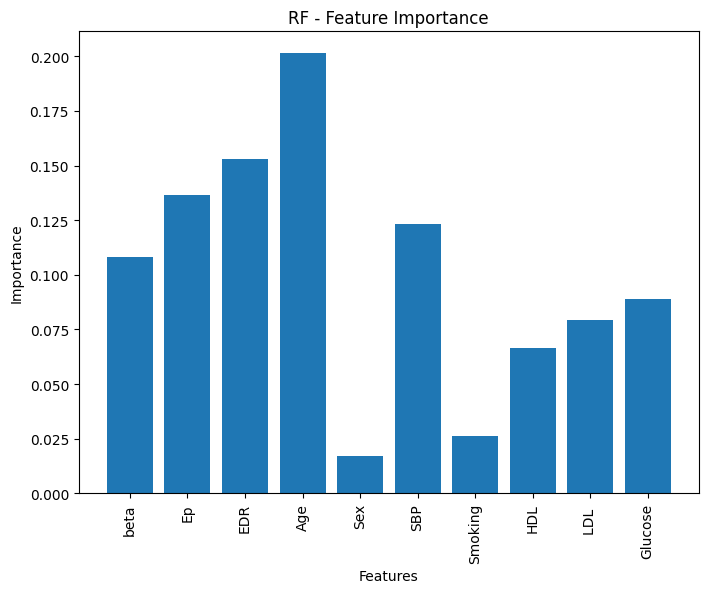

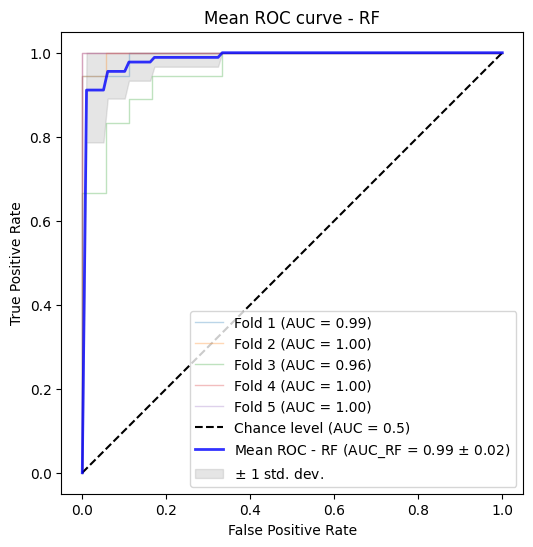

In [9]:
from statistics import mean, stdev
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

# Feature Scaling for input features.
from statistics import mean, stdev
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
X_scaled = scaler.fit_transform(X_resampled)
  
# Create RF classifier object.
rf_classifier = RandomForestClassifier(random_state=42)
  
# Create StratifiedKFold object.
skf_rf_classifier = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
lst_accu_stratified = []
  
for train_index, test_index in skf_rf_classifier.split(X, y):
    X_train_fold, X_test_fold = X_scaled[train_index], X_scaled[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    rf_classifier.fit(X_train_fold, y_train_fold)
    lst_accu_stratified.append(rf_classifier.score(X_test_fold, y_test_fold))
  
# Print the output.
print('List of possible accuracy:', lst_accu_stratified)
print('\nMaximum Accuracy That can be obtained from this model is:',
      max(lst_accu_stratified)*100, '%')
print('\nMinimum Accuracy:',
      min(lst_accu_stratified)*100, '%')
print('\nOverall Accuracy:',
      mean(lst_accu_stratified)*100, '%')
print('\nStandard Deviation is:', stdev(lst_accu_stratified))

# RANDOM FOREST - IMPORTANT FEATURE

importance_rf_classifier = rf_classifier.feature_importances_
# summarize feature importance
for i,v in enumerate(importance_rf_classifier):
	print('Feature: %0d, Score: %.5f' % (i,v))

feature_names = ['beta', 'Ep', 'EDR', 'Age', 'Sex', 'SBP', 'Smoking', 'HDL', 'LDL ', 'Glucose']


# plot feature importance
plt.figure(figsize=(8, 6))
plt.bar(range(len(importance_rf_classifier)), importance_rf_classifier)
plt.title("RF - Feature Importance")
plt.xticks(range(len(importance_rf_classifier)), feature_names, rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()


# ROC CURVE for Random Forest Classifier

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc, RocCurveDisplay

tprs = []
aucs = []
mean_fpr_rf = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(skf_rf_classifier.split(X_scaled, y_resampled)):
    rf_classifier.fit(X_scaled[train], y_resampled[train])
    
    # Plot ROC curve for each fold
    viz = RocCurveDisplay.from_estimator(
        rf_classifier,
        X_scaled[test],
        y_resampled[test],
        name=f"Fold {fold + 1}",  # Add 1 to fold for the updated name
        alpha=0.3,
        lw=1,
        ax=ax,
        plot_chance_level=(fold == skf_rf_classifier.n_splits - 1),
    )
    
    interp_tpr = np.interp(mean_fpr_rf, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr_rf = np.mean(tprs, axis=0)
mean_tpr_rf[-1] = 1.0
mean_auc_rf = auc(mean_fpr_rf, mean_tpr_rf)
std_auc_rf = np.std(aucs)

ax.plot(
    mean_fpr_rf,
    mean_tpr_rf,
    color="b",
    label=r"Mean ROC - RF (AUC_RF = %0.2f $\pm$ %0.2f)" % (mean_auc_rf, std_auc_rf),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr_rf + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr_rf - std_tpr, 0)

ax.fill_between(
    mean_fpr_rf,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve - RF",
)
ax.axis("square")
ax.legend(loc="lower right")
plt.show()

2. Stratified K-fold CV  &  K-nearest Neighbor CLASSIFIER 

List of possible accuracy: [0.9444444444444444, 0.8611111111111112, 0.75, 0.8285714285714286, 0.8571428571428571]

Maximum Accuracy That can be obtained from this model is: 94.44444444444444 %

Minimum Accuracy: 75.0 %

Overall Accuracy: 84.82539682539682 %

Standard Deviation is: 0.06988950354646452

Feature Importance Scores:
Feature: 0, Score: 0.10829
Feature: 1, Score: 0.13646
Feature: 2, Score: 0.15282
Feature: 3, Score: 0.20136
Feature: 4, Score: 0.01703
Feature: 5, Score: 0.12329
Feature: 6, Score: 0.02607
Feature: 7, Score: 0.06629
Feature: 8, Score: 0.07940
Feature: 9, Score: 0.08899


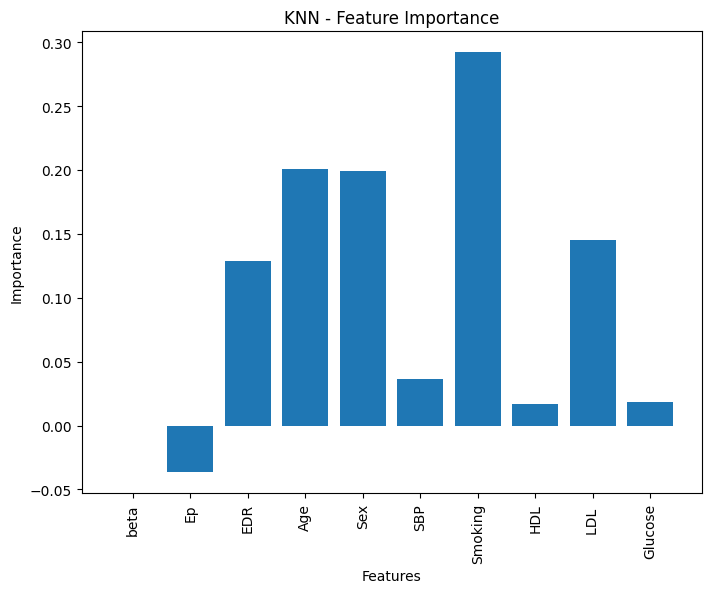

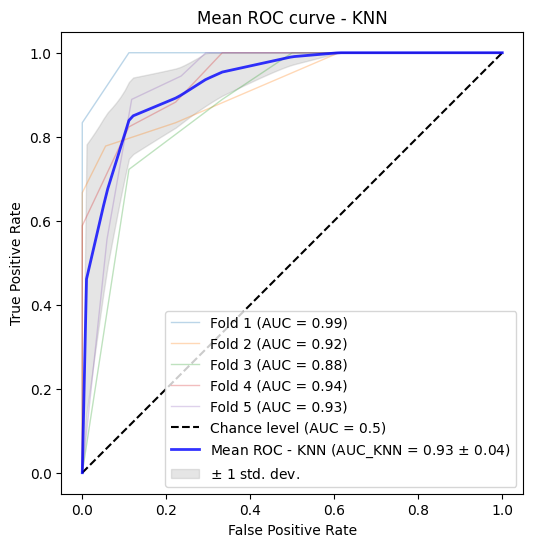

In [10]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from statistics import mean, stdev
import matplotlib.pyplot as plt
import numpy as np

scaler = preprocessing.MinMaxScaler()
X_scaled = scaler.fit_transform(X_resampled)
knn_classifier = KNeighborsClassifier(n_neighbors=6)
skf_knn_classifier = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
lst_accu_stratified = []
feature_importance_scores = {}

for train_index, test_index in skf_knn_classifier.split(X_scaled, y_resampled):
    X_train_fold, X_test_fold = X_scaled[train_index], X_scaled[test_index]
    y_train_fold, y_test_fold = y_resampled[train_index], y_resampled[test_index]
    knn_classifier.fit(X_train_fold, y_train_fold)
    accu_score = knn_classifier.score(X_test_fold, y_test_fold)
    lst_accu_stratified.append(accu_score)
    for i in range(X_scaled.shape[1]):
        perturbed_X_test = X_test_fold.copy()
        perturbed_X_test[:, i] = np.random.permutation(perturbed_X_test[:, i])
        perturbed_accu_score = knn_classifier.score(perturbed_X_test, y_test_fold)
        feature_importance_scores[i] = feature_importance_scores.get(i, 0) + (accu_score - perturbed_accu_score)

total_score = sum(feature_importance_scores.values())
feature_importance_scores = {key: value/total_score for key, value in feature_importance_scores.items()}

print('List of possible accuracy:', lst_accu_stratified)
if lst_accu_stratified:
    print('\nMaximum Accuracy That can be obtained from this model is:', max(lst_accu_stratified)*100, '%')
    print('\nMinimum Accuracy:', min(lst_accu_stratified)*100, '%')
    print('\nOverall Accuracy:', mean(lst_accu_stratified)*100, '%')
    print('\nStandard Deviation is:', stdev(lst_accu_stratified))
    total_score = sum(feature_importance_scores.values())
    feature_importance_scores = {key: value/total_score for key, value in feature_importance_scores.items()}
    print("\nFeature Importance Scores:")
    for i,v in enumerate(importance_rf_classifier):
    	print('Feature: %0d, Score: %.5f' % (i,v))
    feature_names = ['beta', 'Ep', 'EDR', 'Age', 'Sex', 'SBP', 'Smoking', 'HDL', 'LDL ', 'Glucose']
    plt.figure(figsize=(8, 6))
    plt.bar(feature_importance_scores.keys(), feature_importance_scores.values())
    plt.title("KNN - Feature Importance")
    plt.xticks(range(len(importance_rf_classifier)), feature_names, rotation='vertical')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.show()
else:
    print("No accuracy scores available.")

# ROC-AUC
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc, RocCurveDisplay

tprs = []
aucs = []
mean_fpr_knn = np.linspace(0, 1, 100)
fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(skf_knn_classifier.split(X_scaled, y_resampled)):
    knn_classifier.fit(X_scaled[train], y_resampled[train])
    viz = RocCurveDisplay.from_estimator(
        knn_classifier,
        X_scaled[test],
        y_resampled[test],
        name=f"Fold {fold + 1}",
        alpha=0.3,
        lw=1,
        ax=ax,
        plot_chance_level=(fold == skf_knn_classifier.n_splits - 1),
    )
    interp_tpr = np.interp(mean_fpr_knn, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr_knn = np.mean(tprs, axis=0)
mean_tpr_knn[-1] = 1.0
mean_auc_knn = auc(mean_fpr_knn, mean_tpr_knn)
std_auc_knn = np.std(aucs)

ax.plot(
    mean_fpr_knn,
    mean_tpr_knn,
    color="b",
    label=r"Mean ROC - KNN (AUC_KNN = %0.2f $\pm$ %0.2f)" % (mean_auc_knn, std_auc_knn),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr_knn + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr_knn - std_tpr, 0)

ax.fill_between(
    mean_fpr_knn,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve - KNN",
)
ax.axis("square")
ax.legend(loc="lower right")
plt.show()


3. Stratified K-fold CV  &  Support Vector Machine CLASSIFIER 

List of possible accuracy: [0.8333333333333334, 0.8055555555555556, 0.75, 0.7142857142857143, 0.7428571428571429]

Maximum Accuracy That can be obtained from this model is: 83.33333333333334 %

Minimum Accuracy: 71.42857142857143 %

Overall Accuracy: 76.92063492063492 %

Standard Deviation is: 0.04876724197808046

Feature Importance Scores:
Feature: 0, Score: 0.10829
Feature: 1, Score: 0.13646
Feature: 2, Score: 0.15282
Feature: 3, Score: 0.20136
Feature: 4, Score: 0.01703
Feature: 5, Score: 0.12329
Feature: 6, Score: 0.02607
Feature: 7, Score: 0.06629
Feature: 8, Score: 0.07940
Feature: 9, Score: 0.08899


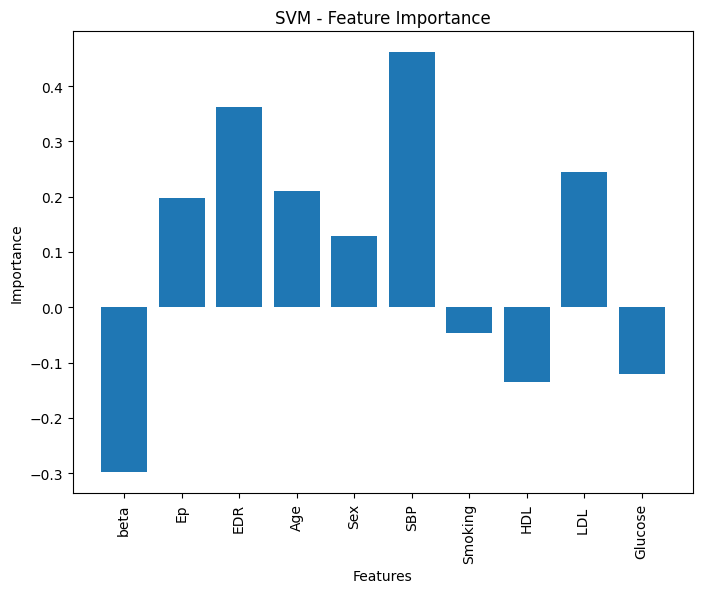

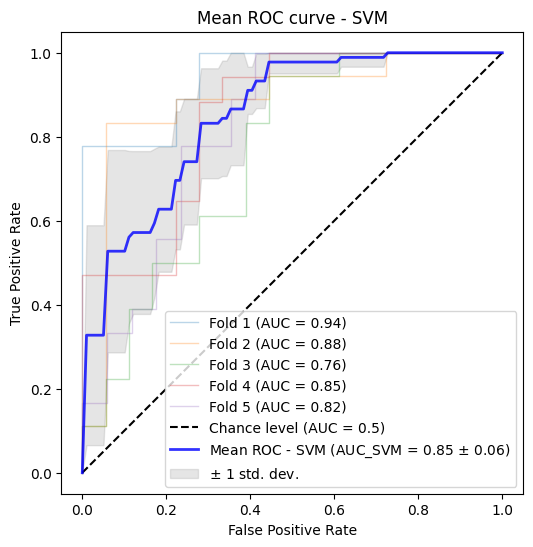

In [11]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from statistics import mean, stdev
scaler = preprocessing.MinMaxScaler()
X_scaled = scaler.fit_transform(X_resampled)
svm_classifier = SVC(kernel='linear', C=1)
skf_svm_classifier = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
lst_accu_stratified = []
feature_importance_scores = {}
for train_index, test_index in skf_svm_classifier.split(X_scaled, y_resampled):
    X_train_fold, X_test_fold = X_scaled[train_index], X_scaled[test_index]
    y_train_fold, y_test_fold = y_resampled[train_index], y_resampled[test_index]
    svm_classifier.fit(X_train_fold, y_train_fold)
    accu_score = svm_classifier.score(X_test_fold, y_test_fold)
    lst_accu_stratified.append(accu_score)
    feature_importance_scores = dict(enumerate(svm_classifier.coef_[0]))
total_score = sum(feature_importance_scores.values())
feature_importance_scores = {key: value / total_score for key, value in feature_importance_scores.items()}
print('List of possible accuracy:', lst_accu_stratified)
if lst_accu_stratified:
    print('\nMaximum Accuracy That can be obtained from this model is:', max(lst_accu_stratified) * 100, '%')
    print('\nMinimum Accuracy:', min(lst_accu_stratified) * 100, '%')
    print('\nOverall Accuracy:', mean(lst_accu_stratified) * 100, '%')
    print('\nStandard Deviation is:', stdev(lst_accu_stratified))
    print("\nFeature Importance Scores:")
    for i, v in enumerate(importance_rf_classifier):
        print('Feature: %0d, Score: %.5f' % (i, v))
    feature_names = ['beta', 'Ep', 'EDR', 'Age', 'Sex', 'SBP', 'Smoking', 'HDL', 'LDL ', 'Glucose']
    plt.figure(figsize=(8, 6))
    plt.bar(feature_importance_scores.keys(), feature_importance_scores.values())
    plt.title("SVM - Feature Importance")
    plt.xticks(range(len(importance_rf_classifier)), feature_names, rotation='vertical')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.show()
else:
    print("No accuracy scores available.")

# ROC-AUC

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc, RocCurveDisplay
tprs = []
aucs = []
mean_fpr_svm = np.linspace(0, 1, 100)
fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(skf_svm_classifier.split(X_scaled, y_resampled)):
    svm_classifier.fit(X_scaled[train], y_resampled[train])
    viz = RocCurveDisplay.from_estimator(svm_classifier, X_scaled[test], y_resampled[test], name=f"Fold {fold + 1}", alpha=0.3, lw=1, ax=ax, plot_chance_level=(fold == skf_svm_classifier.n_splits - 1))
    interp_tpr = np.interp(mean_fpr_svm, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
mean_tpr_svm = np.mean(tprs, axis=0)
mean_tpr_svm[-1] = 1.0
mean_auc_svm = auc(mean_fpr_svm, mean_tpr_svm)
std_auc_svm = np.std(aucs)
ax.plot(mean_fpr_svm, mean_tpr_svm, color="b", label=r"Mean ROC - SVM (AUC_SVM = %0.2f $\pm$ %0.2f)" % (mean_auc_svm, std_auc_svm), lw=2, alpha=0.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr_svm + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr_svm - std_tpr, 0)
ax.fill_between(mean_fpr_svm, tprs_lower, tprs_upper, color="grey", alpha=0.2, label=r"$\pm$ 1 std. dev.")
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], xlabel="False Positive Rate", ylabel="True Positive Rate", title=f"Mean ROC curve - SVM")
ax.axis("square")
ax.legend(loc="lower right")
plt.show()


4. Stratified K-fold CV  &  Decision Tree CLASSIFIER 

List of possible accuracy: [0.8888888888888888, 0.8333333333333334, 0.8333333333333334, 0.9714285714285714, 0.8]

Maximum Accuracy That can be obtained from this model is: 97.14285714285714 %

Minimum Accuracy: 80.0 %

Overall Accuracy: 86.53968253968254 %

Standard Deviation is: 0.06731918009053943

Feature Importance Scores:
Feature: 0, Score: 0.10829
Feature: 1, Score: 0.13646
Feature: 2, Score: 0.15282
Feature: 3, Score: 0.20136
Feature: 4, Score: 0.01703
Feature: 5, Score: 0.12329
Feature: 6, Score: 0.02607
Feature: 7, Score: 0.06629
Feature: 8, Score: 0.07940
Feature: 9, Score: 0.08899


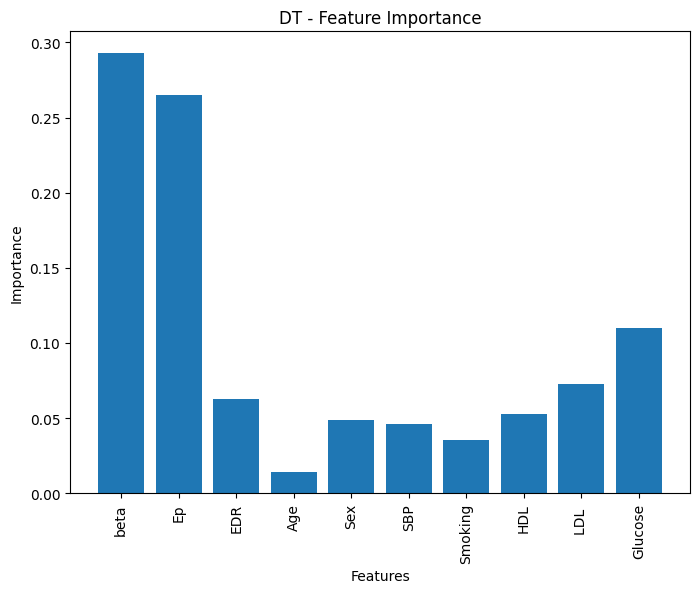

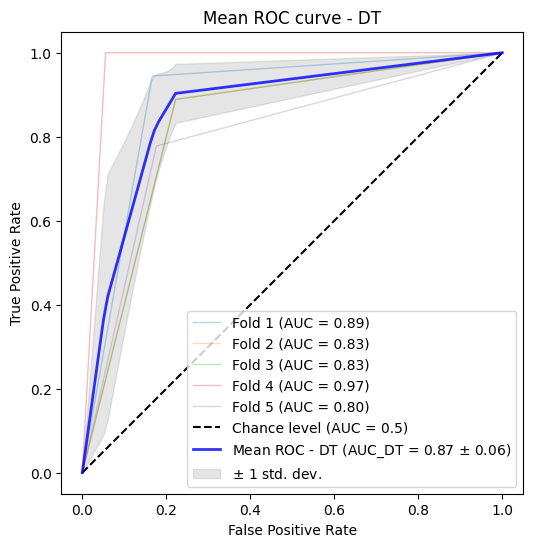

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from statistics import mean, stdev
scaler = preprocessing.MinMaxScaler()
X_scaled = scaler.fit_transform(X_resampled)
dt_classifier = DecisionTreeClassifier(random_state=42)
skf_dt_classifier = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
lst_accu_stratified = []
feature_importance_scores = {}
for train_index, test_index in skf_dt_classifier.split(X_resampled, y_resampled):
    X_train_fold, X_test_fold = X_resampled[train_index], X_resampled[test_index]
    y_train_fold, y_test_fold = y_resampled[train_index], y_resampled[test_index]
    dt_classifier.fit(X_train_fold, y_train_fold)
    accu_score = dt_classifier.score(X_test_fold, y_test_fold)
    lst_accu_stratified.append(accu_score)
    feature_importance_scores_fold = dt_classifier.feature_importances_
    for i, score in enumerate(feature_importance_scores_fold):
        feature_importance_scores[i] = feature_importance_scores.get(i, 0) + score
total_score = sum(feature_importance_scores.values())
feature_importance_scores = {key: value/total_score for key, value in feature_importance_scores.items()}
print('List of possible accuracy:', lst_accu_stratified)
if lst_accu_stratified:
    print('Maximum Accuracy That can be obtained from this model is:', max(lst_accu_stratified)*100, '%')
    print('Minimum Accuracy:', min(lst_accu_stratified)*100, '%')
    print('Overall Accuracy:', mean(lst_accu_stratified)*100, '%')
    print('Standard Deviation is:', stdev(lst_accu_stratified))
    print("Feature Importance Scores:")
    for i,v in enumerate(importance_rf_classifier):
        print('Feature: %0d, Score: %.5f' % (i,v))
    feature_names = ['beta', 'Ep', 'EDR', 'Age', 'Sex', 'SBP', 'Smoking', 'HDL', 'LDL ', 'Glucose']
    plt.figure(figsize=(8, 6))
    plt.bar(feature_importance_scores.keys(), feature_importance_scores.values())
    plt.title("DT - Feature Importance")
    plt.xticks(range(len(importance_rf_classifier)), feature_names, rotation='vertical')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.show()
else:
    print("No accuracy scores available.")

# ROC-AUC

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc, RocCurveDisplay
tprs = []
aucs = []
mean_fpr_dt = np.linspace(0, 1, 100)
fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(skf_dt_classifier.split(X_scaled, y_resampled)):
    dt_classifier.fit(X_scaled[train], y_resampled[train])
    viz = RocCurveDisplay.from_estimator(
        dt_classifier,
        X_scaled[test],
        y_resampled[test],
        name=f"Fold {fold + 1}",
        alpha=0.3,
        lw=1,
        ax=ax,
        plot_chance_level=(fold == skf_dt_classifier.n_splits - 1),
    )
    interp_tpr = np.interp(mean_fpr_dt, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
mean_tpr_dt = np.mean(tprs, axis=0)
mean_tpr_dt[-1] = 1.0
mean_auc_dt = auc(mean_fpr_dt, mean_tpr_dt)
std_auc_dt = np.std(aucs)
ax.plot(mean_fpr_dt, mean_tpr_dt, color="b", label=r"Mean ROC - DT (AUC_DT = %0.2f $\pm$ %0.2f)" % (mean_auc_dt, std_auc_dt), lw=2, alpha=0.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr_dt + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr_dt - std_tpr, 0)
ax.fill_between(mean_fpr_dt, tprs_lower, tprs_upper, color="grey", alpha=0.2, label=r"$\pm$ 1 std. dev.")
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], xlabel="False Positive Rate", ylabel="True Positive Rate", title=f"Mean ROC curve - DT")
ax.axis("square")
ax.legend(loc="lower right")
plt.show()


5. Stratified K-fold CV  &  RF CLASSIFIER + Bagging Classifier (RFBM)

List of possible accuracy: [0.8888888888888888, 0.9444444444444444, 0.8333333333333334, 1.0, 0.9714285714285714]

Maximum Accuracy That can be obtained from this model is: 100.0 %

Minimum Accuracy: 83.33333333333334 %

Overall Accuracy: 92.76190476190476 %

Standard Deviation is: 0.06676674272411684

Feature Importance Scores:
Feature: 0, Score: 0.10829
Feature: 1, Score: 0.13646
Feature: 2, Score: 0.15282
Feature: 3, Score: 0.20136
Feature: 4, Score: 0.01703
Feature: 5, Score: 0.12329
Feature: 6, Score: 0.02607
Feature: 7, Score: 0.06629
Feature: 8, Score: 0.07940
Feature: 9, Score: 0.08899


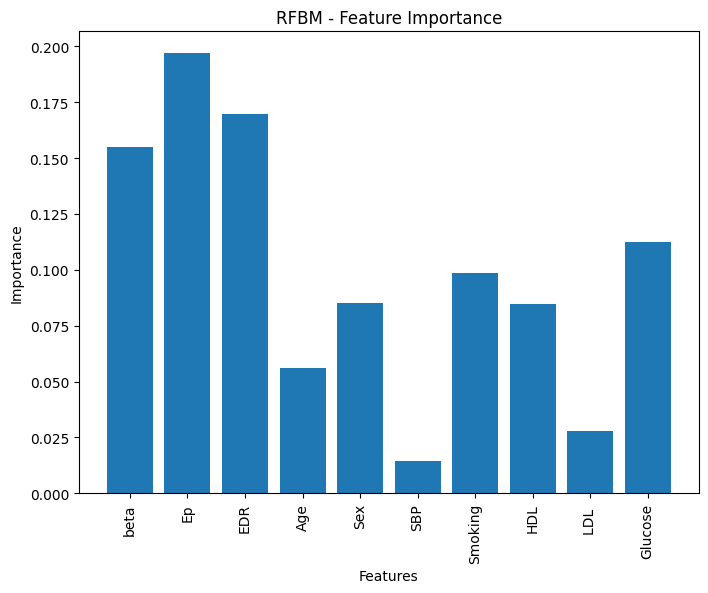

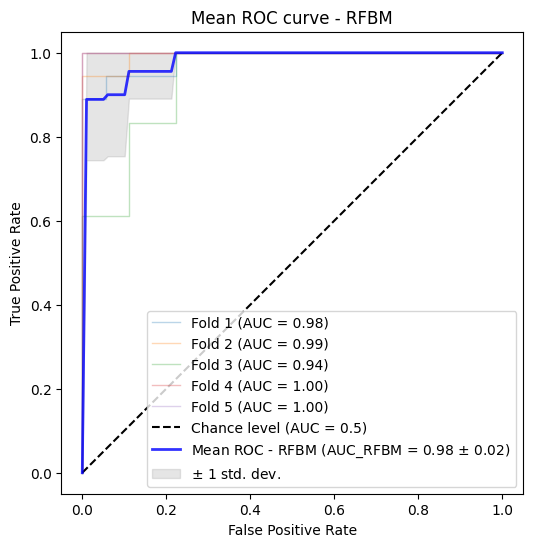

In [15]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import StratifiedKFold
from statistics import mean, stdev
scaler = preprocessing.MinMaxScaler()
X_scaled = scaler.fit_transform(X_resampled)
base_rf_classifier = RandomForestClassifier(random_state=42)
rfbm_classifier = BaggingClassifier(base_rf_classifier, n_estimators=10, random_state=42)
skf_rfbm_classifier = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
lst_accu_stratified = []
feature_importance_scores = {}
for train_index, test_index in skf_rfbm_classifier.split(X_scaled, y_resampled):
    X_train_fold, X_test_fold = X_scaled[train_index], X_scaled[test_index]
    y_train_fold, y_test_fold = y_resampled[train_index], y_resampled[test_index]
    rfbm_classifier.fit(X_train_fold, y_train_fold)
    accu_score = rfbm_classifier.score(X_test_fold, y_test_fold)
    lst_accu_stratified.append(accu_score)
    for i in range(X_scaled.shape[1]):
        perturbed_X_test = X_test_fold.copy()
        perturbed_X_test[:, i] = np.random.permutation(perturbed_X_test[:, i])
        perturbed_accu_score = rfbm_classifier.score(perturbed_X_test, y_test_fold)
        feature_importance_scores[i] = feature_importance_scores.get(i, 0) + (accu_score - perturbed_accu_score)
print('List of possible accuracy:', lst_accu_stratified)
if lst_accu_stratified:
    print('\nMaximum Accuracy That can be obtained from this model is:', max(lst_accu_stratified)*100, '%')
    print('\nMinimum Accuracy:', min(lst_accu_stratified)*100, '%')
    print('\nOverall Accuracy:', mean(lst_accu_stratified)*100, '%')
    print('\nStandard Deviation is:', stdev(lst_accu_stratified))
    total_score = sum(feature_importance_scores.values())
    feature_importance_scores = {key: value/total_score for key, value in feature_importance_scores.items()}
    print("\nFeature Importance Scores:")
    for i,v in enumerate(importance_rf_classifier):
    	print('Feature: %0d, Score: %.5f' % (i,v))
    feature_names = ['beta', 'Ep', 'EDR', 'Age', 'Sex', 'SBP', 'Smoking', 'HDL', 'LDL ', 'Glucose']
    plt.figure(figsize=(8, 6))
    plt.bar(feature_importance_scores.keys(), feature_importance_scores.values())
    plt.title("RFBM - Feature Importance")
    plt.xticks(range(len(importance_rf_classifier)), feature_names, rotation='vertical')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.show()
else:
    print("No accuracy scores available.")

# ROC-AUC
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc, RocCurveDisplay
tprs = []
aucs = []
mean_fpr_rfbm = np.linspace(0, 1, 100)
fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(skf_rfbm_classifier.split(X_scaled, y_resampled)):
    rfbm_classifier.fit(X_scaled[train], y_resampled[train])
    viz = RocCurveDisplay.from_estimator(
        rfbm_classifier,
        X_scaled[test],
        y_resampled[test],
        name=f"Fold {fold + 1}",
        alpha=0.3,
        lw=1,
        ax=ax,
        plot_chance_level=(fold == skf_rfbm_classifier.n_splits - 1),
    )
    interp_tpr = np.interp(mean_fpr_rfbm, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
mean_tpr_rfbm = np.mean(tprs, axis=0)
mean_tpr_rfbm[-1] = 1.0
mean_auc_rfbm = auc(mean_fpr_rfbm, mean_tpr_rfbm)
std_auc_rfbm = np.std(aucs)
ax.plot(
    mean_fpr_rfbm,
    mean_tpr_rfbm,
    color="b",
    label=r"Mean ROC - RFBM (AUC_RFBM = %0.2f $\pm$ %0.2f)" % (mean_auc_rfbm, std_auc_rfbm),
    lw=2,
    alpha=0.8,
)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr_rfbm + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr_rfbm - std_tpr, 0)
ax.fill_between(
    mean_fpr_rfbm,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)
ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate", 
    title=f"Mean ROC curve - RFBM",
)
ax.axis("square")
ax.legend(loc="lower right")
plt.show()


6. Stratified K-fold CV  &  KNN CLASSIFIER + Bagging Classifier (KNNBM)

List of possible accuracy: [0.8888888888888888, 0.8611111111111112, 0.75, 0.8571428571428571, 0.8571428571428571]

Maximum Accuracy That can be obtained from this model is: 88.88888888888889 %

Minimum Accuracy: 75.0 %

Overall Accuracy: 84.28571428571429 %

Standard Deviation is: 0.05357877668593695

Feature Importance Scores:
Feature: 0, Score: 0.10829
Feature: 1, Score: 0.13646
Feature: 2, Score: 0.15282
Feature: 3, Score: 0.20136
Feature: 4, Score: 0.01703
Feature: 5, Score: 0.12329
Feature: 6, Score: 0.02607
Feature: 7, Score: 0.06629
Feature: 8, Score: 0.07940
Feature: 9, Score: 0.08899


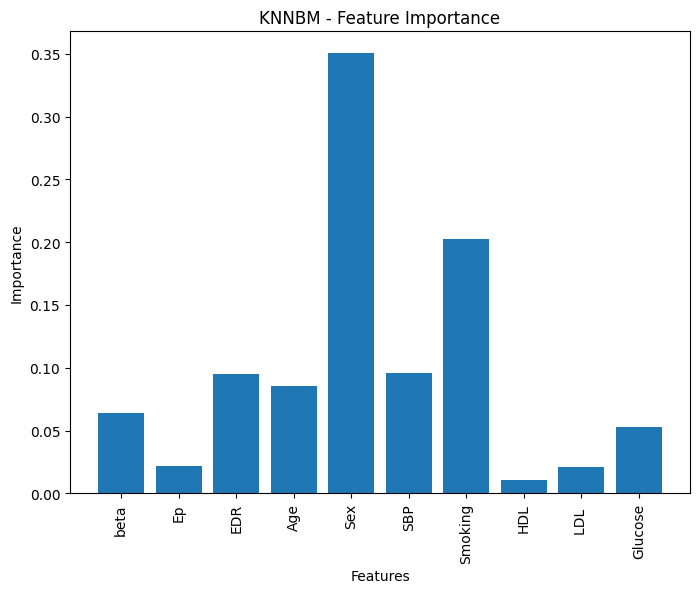

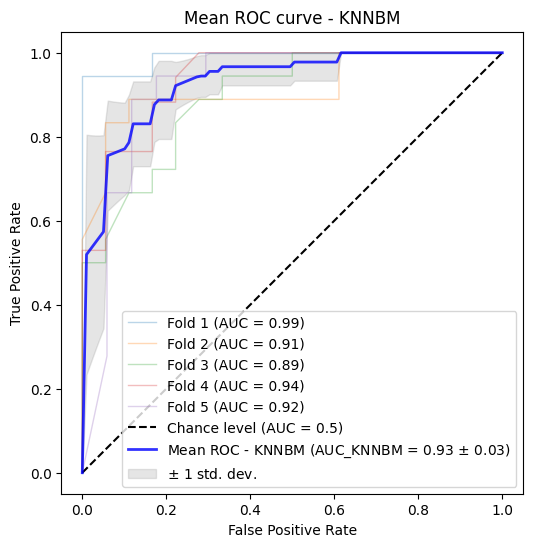

In [16]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import StratifiedKFold
from statistics import mean, stdev

scaler = preprocessing.MinMaxScaler()
X_scaled = scaler.fit_transform(X_resampled)
base_knn_classifier = KNeighborsClassifier(n_neighbors=6)
knnbm_classifier = BaggingClassifier(base_knn_classifier, n_estimators=10, random_state=42)
skf_knnbm_classifier = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
lst_accu_stratified = []
feature_importance_scores = {}
for train_index, test_index in skf_knnbm_classifier.split(X_scaled, y_resampled):
    X_train_fold, X_test_fold = X_scaled[train_index], X_scaled[test_index]
    y_train_fold, y_test_fold = y_resampled[train_index], y_resampled[test_index]
    knnbm_classifier.fit(X_train_fold, y_train_fold)
    accu_score = knnbm_classifier.score(X_test_fold, y_test_fold)
    lst_accu_stratified.append(accu_score)
    for i in range(X_scaled.shape[1]):
        perturbed_X_test = X_test_fold.copy()
        perturbed_X_test[:, i] = np.random.permutation(perturbed_X_test[:, i])
        perturbed_accu_score = knnbm_classifier.score(perturbed_X_test, y_test_fold)
        feature_importance_scores[i] = feature_importance_scores.get(i, 0) + (accu_score - perturbed_accu_score)
print('List of possible accuracy:', lst_accu_stratified)
if lst_accu_stratified:
    print('\nMaximum Accuracy That can be obtained from this model is:',
          max(lst_accu_stratified)*100, '%')
    print('\nMinimum Accuracy:',
          min(lst_accu_stratified)*100, '%')
    print('\nOverall Accuracy:',
          mean(lst_accu_stratified)*100, '%')
    print('\nStandard Deviation is:', stdev(lst_accu_stratified))

    total_score = sum(feature_importance_scores.values())
    feature_importance_scores = {key: value/total_score for key, value in feature_importance_scores.items()}
    print("\nFeature Importance Scores:")
    for i,v in enumerate(importance_rf_classifier):
    	print('Feature: %0d, Score: %.5f' % (i,v))
    feature_names = ['beta', 'Ep', 'EDR', 'Age', 'Sex', 'SBP', 'Smoking', 'HDL', 'LDL ', 'Glucose']
    plt.figure(figsize=(8, 6))
    plt.bar(feature_importance_scores.keys(), feature_importance_scores.values())
    plt.title("KNNBM - Feature Importance")
    plt.xticks(range(len(importance_rf_classifier)), feature_names, rotation='vertical')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.show()
else:
    print("No accuracy scores available.")

# ROC-AUC

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc, RocCurveDisplay

tprs = []
aucs = []
mean_fpr_knnbm = np.linspace(0, 1, 100)
fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(skf_knnbm_classifier.split(X_scaled, y_resampled)):
    knnbm_classifier.fit(X_scaled[train], y_resampled[train])
    viz = RocCurveDisplay.from_estimator(
        knnbm_classifier,
        X_scaled[test],
        y_resampled[test],
        name=f"Fold {fold + 1}",
        alpha=0.3,
        lw=1,
        ax=ax,
        plot_chance_level=(fold == skf_knnbm_classifier.n_splits - 1),
    )
    interp_tpr = np.interp(mean_fpr_knnbm, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
mean_tpr_knnbm = np.mean(tprs, axis=0)
mean_tpr_knnbm[-1] = 1.0
mean_auc_knnbm = auc(mean_fpr_knnbm, mean_tpr_knnbm)
std_auc_knnbm = np.std(aucs)
ax.plot(
    mean_fpr_knnbm,
    mean_tpr_knnbm,
    color="b",
    label=r"Mean ROC - KNNBM (AUC_KNNBM = %0.2f $\pm$ %0.2f)" % (mean_auc_knnbm, std_auc_knnbm),
    lw=2,
    alpha=0.8,
)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr_knnbm + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr_knnbm - std_tpr, 0)
ax.fill_between(
    mean_fpr_knnbm,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)
ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve - KNNBM",
)
ax.axis("square")
ax.legend(loc="lower right")
plt.show()

7. Stratified K-fold CV  &  SVM CLASSIFIER + Bagging Classifier (SVMBM)

List of possible accuracy: [0.8333333333333334, 0.7777777777777778, 0.75, 0.7142857142857143, 0.7714285714285715]

Maximum Accuracy That can be obtained from this model is: 83.33333333333334 %

Minimum Accuracy: 71.42857142857143 %

Overall Accuracy: 76.93650793650794 %

Standard Deviation is: 0.04351928241075432

Feature Importance Scores:
Feature: 0, Score: 0.24347
Feature: 1, Score: 0.09766
Feature: 2, Score: 0.19464
Feature: 3, Score: 0.12311
Feature: 4, Score: 0.29436
Feature: 5, Score: 0.04677
Feature: 6, Score: -0.04814
Feature: 7, Score: -0.09835
Feature: 8, Score: 0.02476
Feature: 9, Score: 0.12173


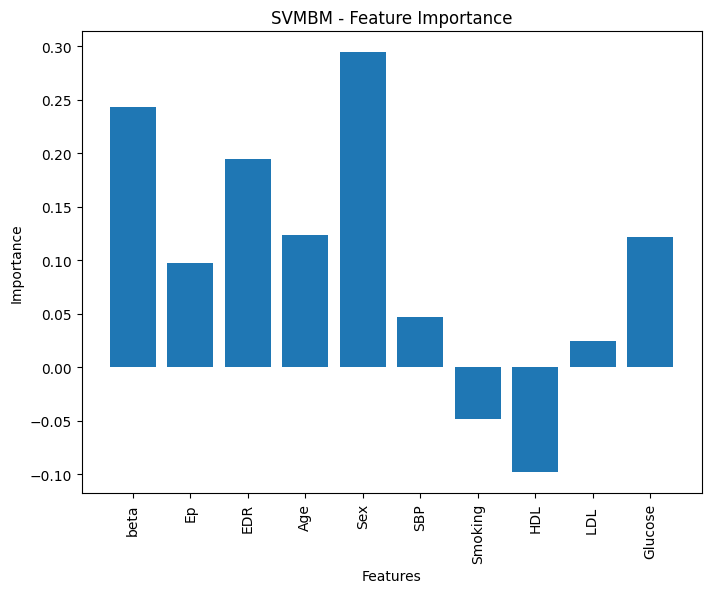

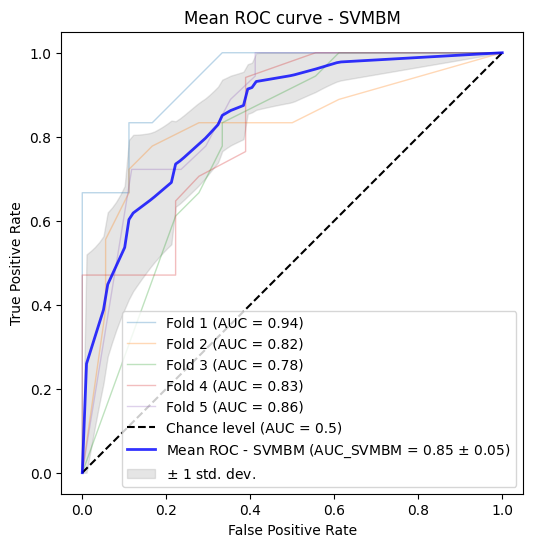

In [17]:
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from statistics import mean, stdev
scaler = preprocessing.MinMaxScaler()
X_scaled = scaler.fit_transform(X_resampled)
base_svm_classifier = SVC(kernel='linear', random_state=42)
svmbm_classifier = BaggingClassifier(base_svm_classifier, n_estimators=10, random_state=42)
skf_svmbm_classifier = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
lst_accu_stratified = []
feature_importance_scores = {}
for train_index, test_index in skf_svmbm_classifier.split(X_scaled, y_resampled):
    X_train_fold, X_test_fold = X_scaled[train_index], X_scaled[test_index]
    y_train_fold, y_test_fold = y_resampled[train_index], y_resampled[test_index]
    svmbm_classifier.fit(X_train_fold, y_train_fold)
    accu_score = svmbm_classifier.score(X_test_fold, y_test_fold)
    lst_accu_stratified.append(accu_score)
    for i in range(X_scaled.shape[1]):
        perturbed_X_test = X_test_fold.copy()
        perturbed_X_test[:, i] = np.random.permutation(perturbed_X_test[:, i])
        perturbed_accu_score = svmbm_classifier.score(perturbed_X_test, y_test_fold)
        feature_importance_scores[i] = feature_importance_scores.get(i, 0) + (accu_score - perturbed_accu_score)
print('List of possible accuracy:', lst_accu_stratified)
if lst_accu_stratified:
    print('\nMaximum Accuracy That can be obtained from this model is:', max(lst_accu_stratified)*100, '%')
    print('\nMinimum Accuracy:', min(lst_accu_stratified)*100, '%')
    print('\nOverall Accuracy:', mean(lst_accu_stratified)*100, '%')
    print('\nStandard Deviation is:', stdev(lst_accu_stratified))
    total_score = sum(feature_importance_scores.values())
    feature_importance_scores = {key: value/total_score for key, value in feature_importance_scores.items()}
    print("\nFeature Importance Scores:")
    for i, v in enumerate(feature_importance_scores.values()):
        print('Feature: %0d, Score: %.5f' % (i, v))
    feature_names = ['beta', 'Ep', 'EDR', 'Age', 'Sex', 'SBP', 'Smoking', 'HDL', 'LDL ', 'Glucose']
    plt.figure(figsize=(8, 6))
    plt.bar(feature_importance_scores.keys(), feature_importance_scores.values())
    plt.title("SVMBM - Feature Importance")
    plt.xticks(range(len(feature_importance_scores)), feature_names, rotation='vertical')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.show()
else:
    print("No accuracy scores available.")

# ROC-AUC

from statistics import mean, stdev
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc, RocCurveDisplay
tprs = []
aucs = []
mean_fpr_svmbm = np.linspace(0, 1, 100)
fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(skf_svmbm_classifier.split(X_scaled, y_resampled)):
    svmbm_classifier.fit(X_scaled[train], y_resampled[train])
    viz = RocCurveDisplay.from_estimator(
        svmbm_classifier,
        X_scaled[test],
        y_resampled[test],
        name=f"Fold {fold + 1}",
        alpha=0.3,
        lw=1,
        ax=ax,
        plot_chance_level=(fold == skf_svmbm_classifier.n_splits - 1),
    )
    interp_tpr = np.interp(mean_fpr_svmbm, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
mean_tpr_svmbm = np.mean(tprs, axis=0)
mean_tpr_svmbm[-1] = 1.0
mean_auc_svmbm = auc(mean_fpr_svmbm, mean_tpr_svmbm)
std_auc_svmbm = np.std(aucs)
ax.plot(
    mean_fpr_svmbm,
    mean_tpr_svmbm,
    color="b",
    label=r"Mean ROC - SVMBM (AUC_SVMBM = %0.2f $\pm$ %0.2f)" % (mean_auc_svmbm, std_auc_svmbm),
    lw=2,
    alpha=0.8,
)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr_svmbm + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr_svmbm - std_tpr, 0)
ax.fill_between(
    mean_fpr_svmbm,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)
ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve - SVMBM",
)
ax.axis("square")
ax.legend(loc="lower right")
plt.show()


8. Stratified K-fold CV  &  Decision Tree CLASSIFIER + Bagging Classifier (DTBM)

List of possible accuracy: [0.8611111111111112, 0.8888888888888888, 0.8888888888888888, 0.9714285714285714, 0.8285714285714286]

Maximum Accuracy That can be obtained from this model is: 97.14285714285714 %

Minimum Accuracy: 82.85714285714286 %

Overall Accuracy: 88.77777777777777 %

Standard Deviation is: 0.05295381787856612

Feature Importance Scores:
Feature: 0, Score: 0.17251
Feature: 1, Score: 0.29792
Feature: 2, Score: 0.08057
Feature: 3, Score: 0.04581
Feature: 4, Score: 0.10461
Feature: 5, Score: 0.06823
Feature: 6, Score: 0.02307
Feature: 7, Score: 0.04548
Feature: 8, Score: 0.01137
Feature: 9, Score: 0.15042


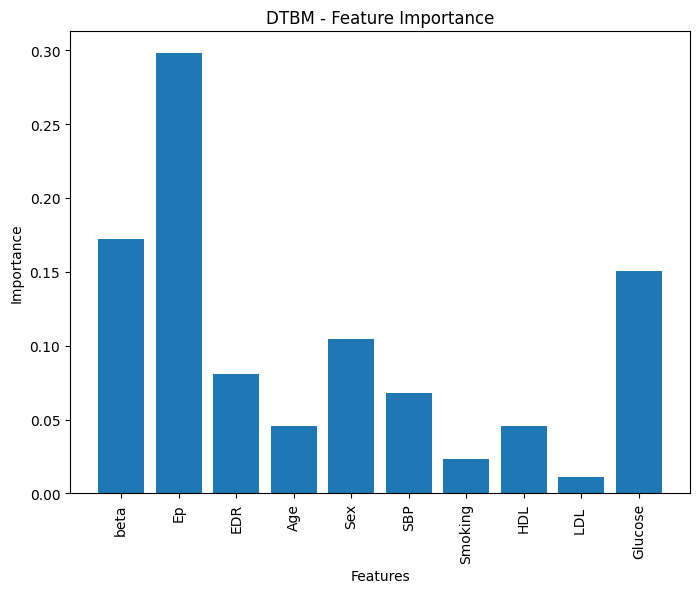

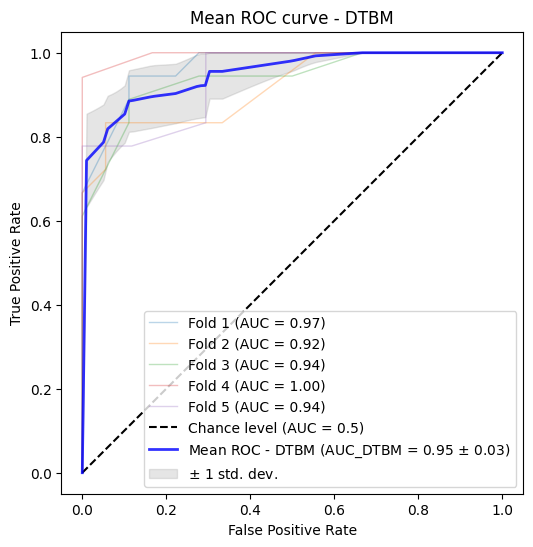

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from statistics import mean, stdev
scaler = preprocessing.MinMaxScaler()
X_scaled = scaler.fit_transform(X_resampled)
base_dt_classifier = DecisionTreeClassifier(random_state=42)
dtbm_classifier = BaggingClassifier(base_dt_classifier, n_estimators=10, random_state=42)
skf_dtbm_classifier = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
lst_accu_stratified = []
feature_importance_scores = {}
for train_index, test_index in skf_dtbm_classifier.split(X_scaled, y_resampled):
    X_train_fold, X_test_fold = X_scaled[train_index], X_scaled[test_index]
    y_train_fold, y_test_fold = y_resampled[train_index], y_resampled[test_index]
    dtbm_classifier.fit(X_train_fold, y_train_fold)
    accu_score = dtbm_classifier.score(X_test_fold, y_test_fold)
    lst_accu_stratified.append(accu_score)
    for i in range(X_scaled.shape[1]):
        perturbed_X_test = X_test_fold.copy()
        perturbed_X_test[:, i] = np.random.permutation(perturbed_X_test[:, i])
        perturbed_accu_score = dtbm_classifier.score(perturbed_X_test, y_test_fold)
        feature_importance_scores[i] = feature_importance_scores.get(i, 0) + (accu_score - perturbed_accu_score)
if lst_accu_stratified:
    total_score = sum(feature_importance_scores.values())
    feature_importance_scores = {key: value/total_score for key, value in feature_importance_scores.items()}
    feature_names = ['beta', 'Ep', 'EDR', 'Age', 'Sex', 'SBP', 'Smoking', 'HDL', 'LDL ', 'Glucose']
    plt.figure(figsize=(8, 6))
    plt.bar(feature_importance_scores.keys(), feature_importance_scores.values())
    plt.title("DTBM - Feature Importance")
    plt.xticks(range(len(feature_importance_scores)), feature_names, rotation='vertical')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.show()

# ROC-AUC

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay
tprs = []
aucs = []
mean_fpr_dtbm = np.linspace(0, 1, 100)
fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(skf_dtbm_classifier.split(X_scaled, y_resampled)):
    dtbm_classifier.fit(X_scaled[train], y_resampled[train])
    viz = RocCurveDisplay.from_estimator(dtbm_classifier, X_scaled[test], y_resampled[test], name=f"Fold {fold + 1}", alpha=0.3, lw=1, ax=ax, plot_chance_level=(fold == skf_dtbm_classifier.n_splits - 1))
    interp_tpr = np.interp(mean_fpr_dtbm, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
mean_tpr_dtbm = np.mean(tprs, axis=0)
mean_tpr_dtbm[-1] = 1.0
mean_auc_dtbm = auc(mean_fpr_dtbm, mean_tpr_dtbm)
std_auc_dtbm = np.std(aucs)
ax.plot(mean_fpr_dtbm, mean_tpr_dtbm, color="b", label=r"Mean ROC - DTBM (AUC_DTBM = %0.2f $\pm$ %0.2f)" % (mean_auc_dtbm, std_auc_dtbm), lw=2, alpha=0.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr_dtbm + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr_dtbm - std_tpr, 0)
ax.fill_between(mean_fpr_dtbm, tprs_lower, tprs_upper, color="grey", alpha=0.2, label=r"$\pm$ 1 std. dev.")
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], xlabel="False Positive Rate", ylabel="True Positive Rate", title=f"Mean ROC curve - DTBM")
ax.axis("square")
ax.legend(loc="lower right")
plt.show()


* 1. ROC-AUC

False Positive Rate (mean_fpr_gbbm): [0.         0.01010101 0.02020202 0.03030303 0.04040404 0.05050505
 0.06060606 0.07070707 0.08080808 0.09090909 0.1010101  0.11111111
 0.12121212 0.13131313 0.14141414 0.15151515 0.16161616 0.17171717
 0.18181818 0.19191919 0.2020202  0.21212121 0.22222222 0.23232323
 0.24242424 0.25252525 0.26262626 0.27272727 0.28282828 0.29292929
 0.3030303  0.31313131 0.32323232 0.33333333 0.34343434 0.35353535
 0.36363636 0.37373737 0.38383838 0.39393939 0.4040404  0.41414141
 0.42424242 0.43434343 0.44444444 0.45454545 0.46464646 0.47474747
 0.48484848 0.49494949 0.50505051 0.51515152 0.52525253 0.53535354
 0.54545455 0.55555556 0.56565657 0.57575758 0.58585859 0.5959596
 0.60606061 0.61616162 0.62626263 0.63636364 0.64646465 0.65656566
 0.66666667 0.67676768 0.68686869 0.6969697  0.70707071 0.71717172
 0.72727273 0.73737374 0.74747475 0.75757576 0.76767677 0.77777778
 0.78787879 0.7979798  0.80808081 0.81818182 0.82828283 0.83838384
 0.84848485 0.85858586 0.8

<>:13: SyntaxWarning: invalid escape sequence '\p'
<>:14: SyntaxWarning: invalid escape sequence '\p'
<>:15: SyntaxWarning: invalid escape sequence '\p'
<>:16: SyntaxWarning: invalid escape sequence '\p'
<>:20: SyntaxWarning: invalid escape sequence '\p'
<>:21: SyntaxWarning: invalid escape sequence '\p'
<>:22: SyntaxWarning: invalid escape sequence '\p'
<>:23: SyntaxWarning: invalid escape sequence '\p'
<>:13: SyntaxWarning: invalid escape sequence '\p'
<>:14: SyntaxWarning: invalid escape sequence '\p'
<>:15: SyntaxWarning: invalid escape sequence '\p'
<>:16: SyntaxWarning: invalid escape sequence '\p'
<>:20: SyntaxWarning: invalid escape sequence '\p'
<>:21: SyntaxWarning: invalid escape sequence '\p'
<>:22: SyntaxWarning: invalid escape sequence '\p'
<>:23: SyntaxWarning: invalid escape sequence '\p'
C:\Users\USER\AppData\Local\Temp\ipykernel_14188\1875239891.py:13: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(mean_fpr_rf, mean_tpr_rf, color="cornflowerblue", linestyle='d

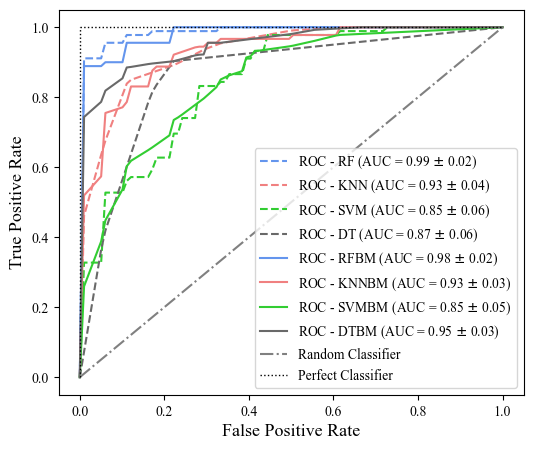

In [21]:
# Extract x and y-axis data from the mean ROC curve

mean_fpr_gbbm, mean_tpr_gbbm

# Print data
print("False Positive Rate (mean_fpr_gbbm):", mean_fpr_gbbm)
print("True Positive Rate (mean_tpr_gbbm):", mean_tpr_gbbm)

import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
# Plot the mean ROC curve
plt.figure(figsize=(6, 5))
plt.plot(mean_fpr_rf, mean_tpr_rf, color="cornflowerblue", linestyle='dashed', label=f"ROC - RF (AUC = {mean_auc_rf:.2f} $\pm$ {std_auc_rf:.2f})")
plt.plot(mean_fpr_knn, mean_tpr_knn, color="lightcoral", linestyle='dashed', label=f"ROC - KNN (AUC = {mean_auc_knn:.2f} $\pm$ {std_auc_knn:.2f})")
plt.plot(mean_fpr_svm, mean_tpr_svm, color="limegreen", linestyle='dashed', label=f"ROC - SVM (AUC = {mean_auc_svm:.2f} $\pm$ {std_auc_svm:.2f})")
plt.plot(mean_fpr_dt, mean_tpr_dt, color="dimgrey", linestyle='dashed', label=f"ROC - DT (AUC = {mean_auc_dt:.2f} $\pm$ {std_auc_dt:.2f})")

plt.plot(mean_fpr_rfbm, mean_tpr_rfbm, color="cornflowerblue", label=f"ROC - RFBM (AUC = {mean_auc_rfbm:.2f} $\pm$ {std_auc_rfbm:.2f})")
plt.plot(mean_fpr_knnbm, mean_tpr_knnbm, color="lightcoral", label=f"ROC - KNNBM (AUC = {mean_auc_knnbm:.2f} $\pm$ {std_auc_knnbm:.2f})")
plt.plot(mean_fpr_svmbm, mean_tpr_svmbm, color="limegreen", label=f"ROC - SVMBM (AUC = {mean_auc_svmbm:.2f} $\pm$ {std_auc_svmbm:.2f})")
plt.plot(mean_fpr_dtbm, mean_tpr_dtbm, color="dimgrey", label=f"ROC - DTBM (AUC = {mean_auc_dtbm:.2f} $\pm$ {std_auc_dtbm:.2f})")
plt.plot([0, 1], [0, 1], linestyle="-.", color="gray", label="Random Classifier")

plt.plot([0, 1], [1, 1], color='black', lw=1, linestyle=':', label='Perfect Classifier')
plt.plot([0, 0], [0, 1], color='black', lw=1, linestyle=':')

# Set graph properties
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel("False Positive Rate", fontsize=13)
plt.ylabel("True Positive Rate", fontsize=13)
plt.legend(loc="lower right", fontsize=9.8)

# Display the plot
plt.show()
